# Multi-agent network

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools. 

One way to approach complicated tasks is through a "divide-and-conquer" approach: create a specialized agent for each task or domain and route tasks to the correct "expert". This is an example of a [multi-agent network](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#network) architecture.

This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using LangGraph.

The resulting graph will look something like the following diagram:

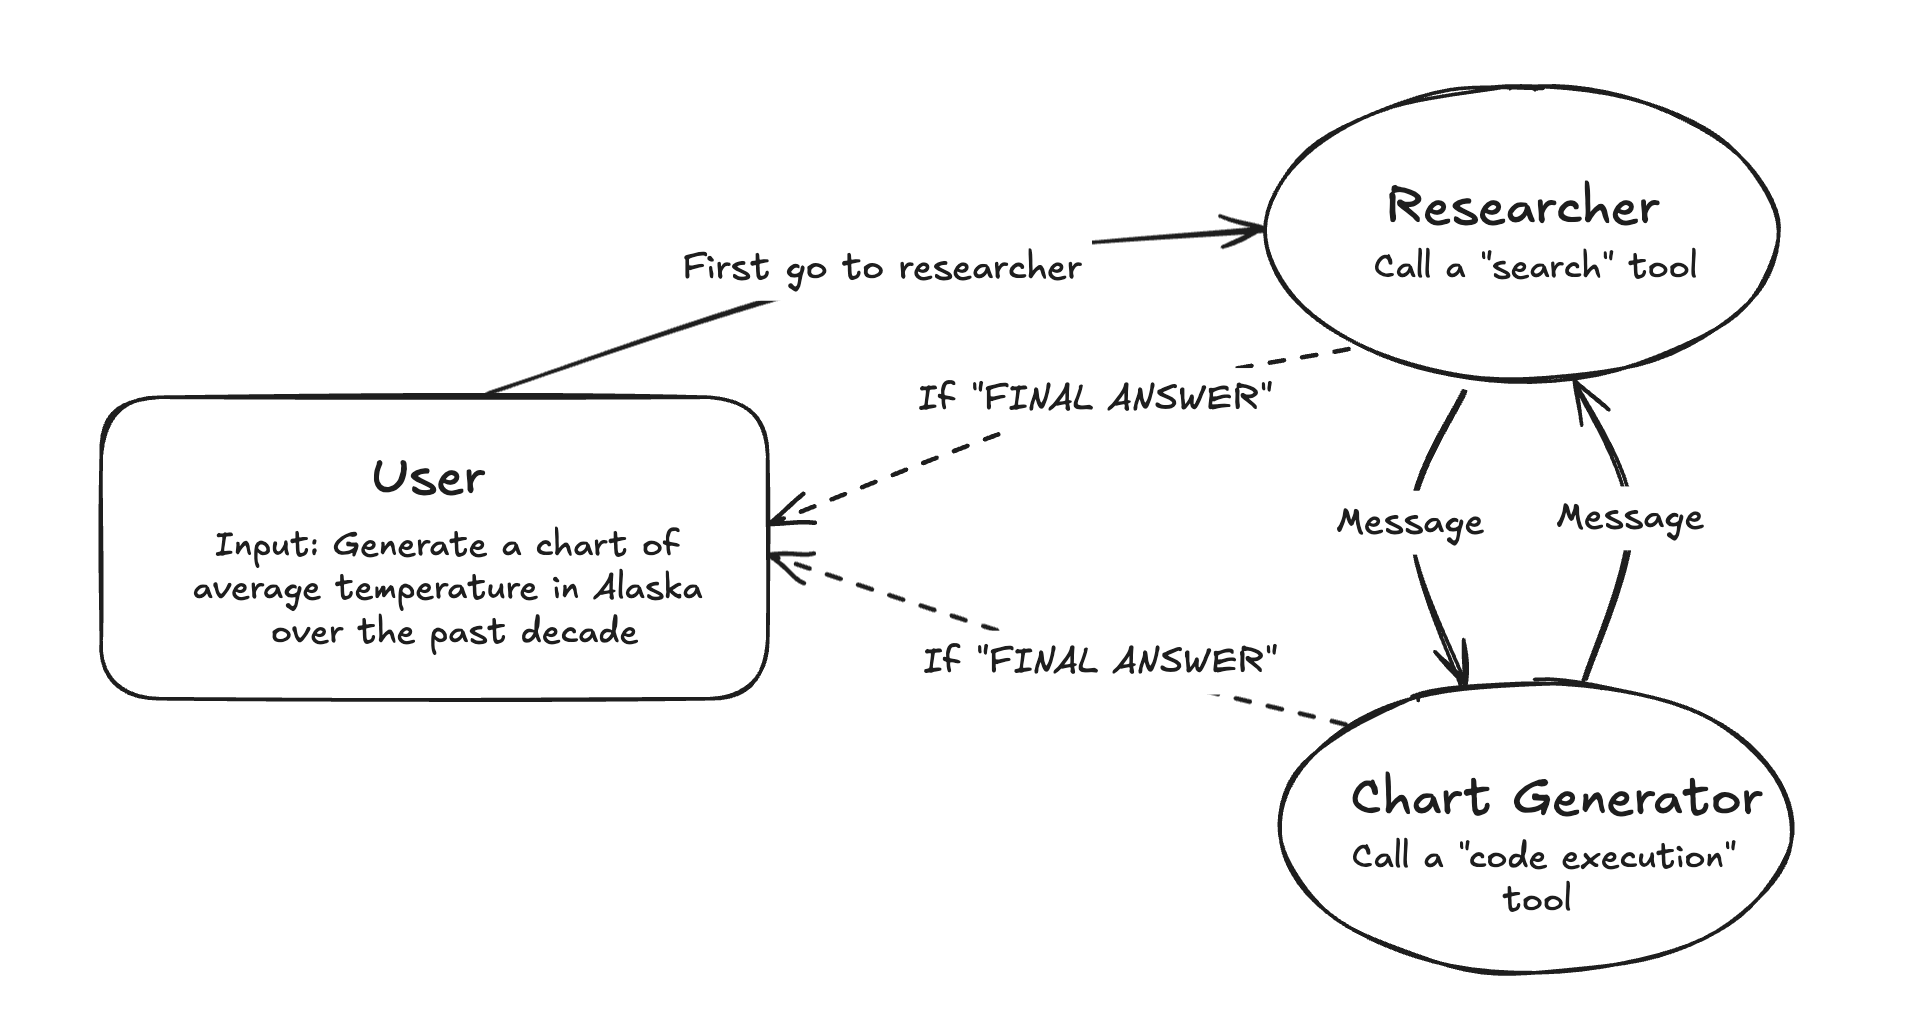

Before we get started, a quick note: this and other multi-agent notebooks are designed to show _how_ you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

## Setup

First, let's install our required packages and set our API keys:

In [1]:
%%capture --no-stderr
%pip install -U langchain_community langchain_openai langchain_experimental matplotlib langgraph

In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

In [3]:
_set_if_undefined("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "modular-plan-graded"

In [4]:
import sys
print(sys.executable)

/Users/allisonjia/Documents/Agents_Research/langchain-academy/lc-academy-env/bin/python3.11


<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Define tools

We will also define some tools that our agents will use in the future

In [5]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()
repl.run("import matplotlib.pyplot as plt")
repl.run("import numpy as np")

# Python REPL Tool 
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    if "Error" in result:
        return f"Execution failed:\n```python\n{code}\n```\nError Output:\n{result}"
    result_str = (f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}")
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

Python REPL can execute arbitrary code. Use with caution.


## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

In [6]:
from typing import Literal, Optional, List, Dict, Any
from langgraph.graph import MessagesState

# Custom State class with specific keys
class State(MessagesState):
    plan: Optional[List[Dict[int, Dict[str, Any]]]]
    execution_trace: Optional[Dict[int, List[Dict[str, Any]]]]
    user_query: Optional[str]
    current_step: int
    replan_flag: Optional[bool]
    last_reason: Optional[str]
    replan_attempts: Optional[Dict[int, Dict[int, int]]]

# Helper method to append entries to Execution Trace
def append_to_step_trace(state, step: int, new_entry: Dict[str, Any]) -> Dict[int, List[Dict[str, Any]]]:
    trace = state.get("execution_trace", {}) or {}
    if step not in trace:
        trace[step] = []
    trace[step].append(new_entry)
    return trace

MAX_REPLANS = 3

### Define Agent Nodes

We now need to define the nodes.

First, we'll create a utility to create a system prompt for each agent.

In [7]:
# System prompt for researcher and chart generator agents
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress." 
        f"\n{suffix}"
    )

In [8]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command
import json

# Initialize LLMs
llm = ChatOpenAI(model="gpt-4o")
reasoning_llm = ChatOpenAI(model="o1")

# Planner prompt
def plan_prompt(state):
    replan_flag = state.get("replan_flag", False)
    user_query = state.get("user_query", state["messages"][0].content)
    prior_plan = state.get("plan", [])[-1] if state.get("plan") else {}
    replan_reason = state.get("last_reason", "")
    execution_trace = state.get("execution_trace", {})

    planning_context = f"""
        You are the Planner of a collaborative multi-agent system. Your job is to decompose the user's query into a concise high-level plan consisting of specific subtasks for three agents: `researcher`, `chart_generator`, and `traj_eval`.
        
        Respond ONLY with a valid JSON object in the following format (do not include explanations or markdown):
        
        {{
          "1": {{
            "agent": "researcher | chart_generator | traj_eval",
            "action": "string",
            "goal": "string",
            "pre_conditions": ["string", "string", "..."],
            "post_conditions": ["string", "string", "..."]
          }},
          "2": {{
            "agent": "researcher | chart_generator | traj_eval",
            "action": "string",
            "goal": "string",
            "pre_conditions": ["string"],
            "post_conditions": ["string"]
          }},
          "3": {{
            "agent": "researcher | chart_generator | traj_eval",
            "action": "string",
            "goal": "string",
            "pre_conditions": ["string"],
            "post_conditions": ["string"]
          }}
        }}
        
        System Overview:
        - `researcher` uses Tavily web search to retrieve factual information.
        - `chart_generator` makes visualizations from structured data given by the researcher.
        - `traj_eval` evaluates the overall plan and execution after task is complete.
        """

    if replan_flag:
        planning_context += f"""
            The previous plan was partially completed and needs revision. Reason for revision: {replan_reason}.
            
            Previous plan:
            {json.dumps(prior_plan, indent=2)}
            
            Overall execution trace: 
            {json.dumps(execution_trace, indent=2)}
            
            When replanning:
            - Identify the step that failed or returned incomplete results.
            - REWRITE that step instead of adding a new one.
            - Keep the step number the same (e.g., Step 0 remains Step 0).
            - If other steps remain valid, leave them unchanged.
            - Your new plan should fully replace the previous one, while maintaining logical structure and valid JSON format.
            """
    else:
        planning_context += "Generate a complete plan for the task starting from scratch."

    planning_context += f"""
        Now, based on the user query:
        "{user_query}", generate the plan as a valid JSON object following the structure above.
        """
    return HumanMessage(content=planning_context)

# Planner Node 
def planner_node(state: State) -> Command[Literal["orchestrator"]]:
    result = reasoning_llm.invoke([plan_prompt(state)])
    try:
        parsed_plan = json.loads(result.content)
    except json.JSONDecodeError:
        raise ValueError("Planner returned invalid JSON.")

    existing_plans = state.get("plan", [])
    replan = state.get("replan_flag", False)

    # Append updated plan to state['plan']
    updated_plan = existing_plans + [parsed_plan] if replan else [parsed_plan]

    return Command(
        update={
            "plan": updated_plan,
            "messages": [HumanMessage(content=result.content, name="replan" if replan else "initial_plan")],
            "user_query": state.get("user_query", state["messages"][0].content),
            "current_step": state.get("current_step", 0),
            "execution_trace": state.get("execution_trace", []),
        },
        goto="orchestrator",
    )

In [ ]:
def orchestrator_prompt(state):
    step = state.get("current_step", 0)
    if step == 0:
        step_evals = []
    else:
        step_evals = state.get("execution_trace")[step][-1]["metrics"]
    return HumanMessage(content=f"""
        You are the Orchestrator in a multi-agent system with three agents: `researcher`, `chart_generator`, and `traj_eval`.
        
        Your responsibilities:
        1. Decide whether the current plan needs revision (`replan`: true/false).
        2. Decide which agent to call next (`goto`: one of `"researcher"`, `"chart_generator"`, `"traj_eval"`, or `"planner"`).
        3. Provide a 1-sentence justification for your decision (`reason`: string).
        
        Use the evaluation scores, execution trace, and current step to inform your decision. 
        
        Guidelines:
        - If the current step is partially completed, and the remaining subgoal still needs work, set `"replan": true` and `"goto": "planner"`.
        - If the current step has been fully completed, even across multiple agent calls, and performance has improved, move to the next agent.
        - If multiple failures have occurred with no improvement, either move on with your existing knowledge or replan using a different approach. Explain your final decision.
        - Never modify a goal directly; instead, indicate 'replan' and provide a reason.
        - If the step was just replanned and agents have not yet acted on the new plan, **do not request replanning again**. Allow agents to attempt the revised step first by calling the agent for the current step in the current plan.
        
         Inputs:
        - User query: {state.get("user_query", "[Missing]")}
        - Current plan: {state.get("plan")[-1]}
        - Evaluations for previous step: {step_evals}
        - Previous step: {step}
        - Just replanned: {state.get("replan_flag")}
        
        Respond in the following JSON format **with no additional explanation**:
        
        {{
          "replan": <true|false>,
          "goto": "<agent_name>",
          "reason": "<1 sentence explanation>"
        }}
    """)
    
def orchestrator_node(
    state: State,
) -> Command[Literal["researcher", "chart_generator", "traj_eval", "planner"]]:
    full_prompt = [orchestrator_prompt(state)]
    result = reasoning_llm.invoke(full_prompt)

    try:
        parsed = json.loads(result.content)
        replan = parsed["replan"]
        goto = parsed["goto"]
        reason = parsed["reason"]
    except Exception as e:
        raise ValueError(f"Invalid orchestrator JSON: {result.content}") from e

    step = state.get("current_step", 0)
    plan_version = len(state.get("plan", [])) - 1
    replan_attempts = state.get("replan_attempts", {})
    step_replans = replan_attempts.get(step, {}).get(plan_version, 0)
    
    updates = {
        "messages": [HumanMessage(content=result.content, name="orchestrator")],
        "last_reason": reason,
    }

    # If just replanned, resume at current step. If just replanned and calls replan again, resume at current step.
    if state.get("replan_flag"):
        print(f"Skipping REPLAN: Step {step} was just replanned.")
        updates["replan_flag"] = False  # allow replanning again later
        updates["current_step"] = step  # stay on current step
        return Command(update=updates, goto=state.get("plan")[-1][str(state.get("current_step"))]["agent"])

    if (replan and step_replans >= MAX_REPLANS):
        # We've replanned too many times — skip or move forward
        print(f"Max replans reached for step {step} plan {plan_version}.")
        updates["replan_flag"] = False
        updates["current_step"] = int(step) + 1
        return Command(update=updates, goto=state.get("plan")[-1][str(state.get("current_step") + 1)]["agent"])  

    # If replanning is necessary, goto planner and retry current step
    if replan:
        replan_attempts.setdefault(step, {})[plan_version] = step_replans + 1
        updates["replan_attempts"] = replan_attempts
        updates["replan_flag"] = True
        updates["current_step"] = step  # retry current step
        return Command(update=updates, goto="planner")

    # If replanning is not necessary, goto next agent and increment current step
    # If the current agent is still responsible for this step, don’t increment
    updates["current_step"] = step + 1
    updates["replan_flag"] = False
    return Command(update=updates, goto=goto)

In [10]:
# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(f"""
        You are the Researcher. You can ONLY perform research by using the provided search tool (tavily_tool). 
        Your only job is to find and return exact numerical values (no approximations) based on the user's request, formatted in a clean structured format.  
        Only include values explicitly stated in your sources.  
        Do NOT infer missing values.  
        When you have found the necessary information, end your output.  
        Do NOT attempt to take further actions.
    """),
)

def research_node(
    state: State,
) -> Command[Literal["research_eval"]]:
    result = research_agent.invoke(state)
    goto = "research_eval"
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )

    # Create new entry for execution_trace
    new_context = {
        "step": state.get("current_step"),
        "agent": "researcher",
        "output": result["messages"][-1].content,
        "tool_calls": [m.content for m in result["messages"] if isinstance(m, ToolMessage)],
        "plan_version": len(state.get("plan")) - 1
    }

    return Command(
        update={
            "messages": result["messages"],
            "execution_trace": append_to_step_trace(state, state.get('current_step'), new_context),
        },
        goto="research_eval"
    )

In [11]:
# Research evaluation
context_relevance_prompt = f"""For context relevance, you should rate the SEARCH RESULT/CONTEXT based on its relevance to the USER QUERY. You should rate the search result on a scale of 0 to 3, where:
    0: The SEARCH RESULT/CONTEXT has no relevance to the USER QUERY.
    1: The SEARCH RESULT/CONTEXT has low relevance to the USER QUERY. It may contain some information that is very slightly related to the user query but not enough to answer it. The search result contains some references or very limited information about some entities present in the user query. In case the query is a statement on a topic, the search result should be tangentially related to it.
    2: The SEARCH RESULT/CONTEXT has medium relevance to the USER QUERY. If the user query is a question, the search result may contain some information that is relevant to the user query but not enough to answer it. If the user query is a search phrase/sentence, either the search result is centered around most but not all entities present in the user query, or if all the entities are present in the result, the search result while not being centered around it has medium level of relevance. In case the query is a statement on a topic, the search result should be related to the topic.
    3: The SEARCH RESULT/CONTEXT has high relevance to the USER QUERY. If the user query is a question, the search result contains information that can answer the user query. Otherwise, if the search query is a search phrase/sentence, it provides relevant information about all entities that are present in the user query and the search result is centered around the entities mentioned in the query. In case the query is a statement on a topic, the search result should be either directly addressing it or be on the same topic.
    
    You should think step by step about the user query and the search result and rate the search result. Be critical and strict with your ratings to ensure accuracy.
    Think step by step about the user query and the search result and rate the search result. Provide a reasoning for your rating.
"""

groundedness_prompt = f"""For groundedness, you are an information overlap classifier; providing the overlap of information (entailment or groundedness) between the SEARCH RESULT/CONTEXT and RESPONSE. You should rate the groundedness on a scale of 0 to 3, where:
    0: RESPONSE is not supported at all by the SEARCH RESULT/CONTEXT.
    1: RESPONSE has very weak or indirect support; mostly speculative.
    2: RESPONSE has partial support; some information aligns but important parts are missing or unclear.
    3: RESPONSE that is directly supported by the context should be considered grounded and should get a high score. Statements of doubt, that admissions of uncertainty or not knowing the answer are considered abstention, and should be counted as the most overlap and therefore get a max score of 3. 

    Be cautious of false positives; ensure that high scores are only given when there is clear supporting evidence.
    Consider indirect or implicit evidence to avoid penalizing potentially factual claims due to lack of explicit support.
    Pay special attention to ensure that indirect evidence is not mistaken for direct support.
"""

answer_completion_prompt = f"""The researcher's role is strictly to retrieve and present factual, numerical information based on the user's query. The researcher should not attempt to generate charts.
When grading **Answer Completion**, only evaluate whether the researcher's response satisfies the fact-finding portion of the query. Do not penalize them for not completing the full task or generating visual output.
You should rate the answer completion on a scale of 0 to 3, where:
    0: RESPONSE is irrelevant, hallucinates data, or does not address the factual request.  
    1: RESPONSE addresses a minor part of the factual request, or includes significant errors, omissions, or approximations. Some attempt is made, but the information is incomplete or mostly unhelpful. 
    2: RESPONSE covers many aspects of the factual request and contains mostly accurate data, but has some gaps (e.g., missing some data, approximations, or unclear formatting).
    3: RESPONSE directly and fully answers the factual component of the user query. It includes all requested values in an accurate and well-structured format, grounded in source material.
"""

def research_eval_prompt(state):
    
    return HumanMessage(f"""Your task is to evaluate the quality of the researcher's work based on 3 key criteria: context relevance, groundedness, and answer completion.

    {context_relevance_prompt} 
    {groundedness_prompt} 
    {answer_completion_prompt} 

    Respond ONLY with a valid JSON object in this format:
    {{
      "context_relevance": {{
        "score": 0-3,
        "reason": "string"
      }},
      "groundedness": {{
        "score": 0-3,
        "reason": "string"
      }},
      "answer_completion": {{
        "score": 0-3,
        "reason": "string"
      }}
    }}
   
    QUERY: {state.get("plan")[-1][str(state.get("current_step"))]["goal"]} \n
    CONTEXT (Search Results): {state.get("execution_trace")[state.get("current_step")][-1]["tool_calls"]} \n
    RESEARCHER RESPONSE: {state.get("execution_trace")[state.get("current_step")][-1]["output"]}
    """)

def research_eval_node(state) -> Command[Literal["orchestrator"]]:
    result = reasoning_llm.invoke([research_eval_prompt(state)])
    try:
        parsed_eval = json.loads(result.content)
    except json.JSONDecodeError:
        # fallback if LLM gives malformed output
        parsed_eval = {
            "context_relevance": {"score": 0, "reason": "Could not parse LLM response."},
            "groundedness": {"score": 0, "reason": "Could not parse LLM response."},
            "answer_completion": {"score": 0, "reason": "Could not parse LLM response."}
        }

    # Create new entry for execution_trace
    eval_entry = {
        "step": state.get("current_step"),
        "agent": "research_eval",
        "metrics": parsed_eval, 
        "plan_version": len(state.get("plan")) - 1
    }
    # Build a natural language summary
    summary = (
        f"Research Evaluation:\n"
        f"- Context Relevance: {parsed_eval['context_relevance']['score']}/3 — {parsed_eval['context_relevance']['reason']}\n"
        f"- Groundedness: {parsed_eval['groundedness']['score']}/3 — {parsed_eval['groundedness']['reason']}\n"
        f"- Answer Completion: {parsed_eval['answer_completion']['score']}/3 — {parsed_eval['answer_completion']['reason']}"
    )
    eval_msg = HumanMessage(content=summary, name="research_eval")

    return Command(
        update={
            "messages": [eval_msg],
            "execution_trace": append_to_step_trace(state, state.get("current_step"), eval_entry)
        },
        goto="orchestrator"
    )


In [12]:
# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You are a Chart Generator. You can only generate charts using simple Python. Try to avoid importing external libraries. You are working with a researcher colleague."
    ),
)

def chart_node(state: State) -> Command[Literal["chart_eval"]]:
    result = chart_agent.invoke(state)
    goto = "chart_eval"
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    chart_log = {
        "step": state.get("current_step"),
        "code": result["messages"][-2].content if len(result["messages"]) >= 2 else "",
        "output": result["messages"][-1].content,
        "plan_version": len(state.get("plan")) - 1
    }
    return Command(
        update={
            "messages": result["messages"],
            "execution_trace": append_to_step_trace(state, state.get("current_step"), chart_log)
        },
        goto="chart_eval"
    )

In [ ]:
# Chart evaluation
def chart_eval_prompt(state):
    return HumanMessage(f"""
        Your task is to evaluate the chart generation code based on three criteria: Accuracy, Formatting Quality, and Answering the User Query.
        For each criterion, assign a score from 0 to 3 following the detailed guidelines below, and provide a short 1–2 sentence explanation for your score.
        
        For accuracy, use Researcher Context as your ground truth:
        0: The chart does not reflect the data or plots incorrect values/relationships.
        1: The chart has significant errors (e.g., wrong labels, major mismatches in data) but shows some partial attempt.
        2: The chart is mostly correct with minor, non-critical errors.
        3: The chart is completely accurate: correct data, correct relationships, correct calculations.
        
        For formatting quality:
        0: The chart is poorly formatted: missing important elements like titles, axis labels, or has unreadable text.
        1: Basic elements are present but formatting is cluttered, confusing, or difficult to read.
        2: The chart is mostly clean and readable with only minor formatting issues.
        3: The chart is well-formatted with clear titles, labeled axes, readable scales, appropriate legends, and an overall clean presentation.
        
        For answer relevance to the query:
        0: The chart and response are irrelevant to the query or misinterprets the task.
        1: The chart or response partially addresses the query but misses major elements or misunderstands key parts.
        2: The chart and response mostly answer the query but could be more precise or complete.
        3: The chart and response directly and fully answer the query with an appropriate and complete visual representation.
        
        Final Instructions:
        Think carefully and step-by-step about each dimension.
        Be critical and strict to ensure only high-quality charts receive high scores.
        
        Respond ONLY with a valid JSON object in this format:
            {{
              "accuracy": {{
                "score": 0-3,
                "reason": "string"
              }},
              "formatting": {{
                "score": 0-3,
                "reason": "string"
              }},
              "answer_relevance": {{
                "score": 0-3,
                "reason": "string"
              }}
            }}
        
        Researcher Context: {state.get("execution_trace")[state.get("current_step")-1][-2]["output"]}
        Chart Code: {state.get("execution_trace")[state.get("current_step")][-1]["code"]}
        Chart Response: {state.get("execution_trace")[state.get("current_step")][-1]["output"]}
        Query: {state.get("plan")[-1][str(state.get("current_step"))]["goal"]} 
    """)

def chart_eval_node(state) -> Command[Literal["orchestrator"]]:
    full_prompt = [chart_eval_prompt(state)]
    result = reasoning_llm.invoke(full_prompt)
    try:
        parsed_eval = json.loads(result.content)
    except json.JSONDecodeError:
        # fallback if LLM gives malformed output
        parsed_eval = {
            "accuracy": {"score": 0, "reason": "Could not parse LLM response."},
            "formatting": {"score": 0, "reason": "Could not parse LLM response."},
            "answer_relevance": {"score": 0, "reason": "Could not parse LLM response."}
        }
    eval_entry = {
        "step": state.get("current_step"),
        "agent": "chart_eval",
        "metrics": parsed_eval,
        "plan_version": len(state.get("plan")) - 1
    }
    # Build a natural language summary
    summary = (
        f"Chart Evaluation:\n"
        f"- Accuracy: {parsed_eval['accuracy']['score']}/3 — {parsed_eval['accuracy']['reason']}\n"
        f"- Formatting: {parsed_eval['formatting']['score']}/3 — {parsed_eval['formatting']['reason']}\n"
        f"- Answer Relevance: {parsed_eval['answer_relevance']['score']}/3 — {parsed_eval['answer_relevance']['reason']}"
    )
    eval_msg = HumanMessage(content=summary, name="chart_eval")
    goto = "orchestrator"
    return Command(
        update={
            "messages": [eval_msg],
            "execution_trace": append_to_step_trace(state, state.get("current_step"), eval_entry)
        },
        goto="orchestrator"
    )
    

In [14]:
def traj_eval_prompt(state):
    return HumanMessage(content=f"""
        Context:
        You have just completed a multi‑agent run from orchestration to research to chart‑generation, and you have now arrived at the final explanation.
        
        Task:
        Critically assess three distinct aspects of the run:
        1. Trajectory Execution: How effective was the actual sequence of tool calls and agent outputs in progressing toward the user’s goal?
        2. Plan Quality: Was the intended plan and any potential revisions well-constructed, independent of how well they were carried out?
        3. Plan Adherence: Did the agents follow the initial plan (or its revisions)? If deviations occurred, were they justified based on failures in earlier steps or new observations?
        
        Respond ONLY with a valid JSON object in the following format:
        {{
          "trajectory_execution": {{
            "score": 0-3,
            "reason": "string"
          }},
          "plan_quality": {{
            "score": 0-3,
            "reason": "string"
          }},
          "plan_adherence": {{
            "score": 0-3,
            "reason": "string"
          }}, 
          "strengths": {{
            "reason": "string"
          }}, 
          "weaknesses": {{
            "reason": "string"
          }}
        }}
        ---
        Use the following criteria:

        1. **Trajectory Execution (0-3)**:
            Score:
            0: Agents made wrong or unnecessary calls. Critical steps were skipped or repeated without purpose. Generated outputs were off-topic, hallucinated, or contradictory. Confusion between agent roles. User goal was not meaningfully addressed.
            1: Several unnecessary or misordered agent/tool use. Some factual errors or under-specified steps. Redundant or partially irrelevant tool calls. Weak or ambiguous agent outputs at one or more steps
            2: Some minor inefficiencies or unclear transitions. Moments of stalled progress, but ultimately resolved. The agents mostly fulfilled their roles, and the conversation mostly fulfilled answering the query.
            3: Agent handoffs were well-timed and logical. Tool calls were necessary, sufficient, and accurate. No redundancies, missteps, or dead ends. Progress toward the user query was smooth and continuous. No hallucination or incorrect outputs
            
        For trajectory evaluation, provide a 1–2 sentence justification citing specific features of the execution trace and why it succeeded or failed to accomplish the task effectively. 
        Here is the execution trace: {state.get("execution_trace")}.
        
        2. **Plan Quality (0–3)**:
            Now evaluate all iterations of the intended plan using the following criteria:
            - Completeness: Were all necessary steps accounted for?
            - Executability: Was the plan clearly actionable by the agents?
            - Optimality: Did it minimize unnecessary steps or tool use?
            - Representation: Was the plan clearly expressed and logically structured?
            - Generalization: Would the plan have worked for similar but slightly varied queries?
            - Efficiency: Did the plan aim for concise and timely progress?

            Score:
            0: Missing key subgoals or agents. Contradictory or ambiguous logic. Steps cannot be executed by available agents. Plan would not generalize to similar inputs. Plan includes redundant, circular, or irrelevant steps. Plan is poorly structured or difficult to understand.
            1: Some relevant steps included, but incomplete coverage. Minor logic or ordering issues. Plan could be executed with workarounds. Limited generalizability (overfit to current input). Verbose or slightly confusing articulation. Some unnecessary or low-value step
            2: All necessary steps present. Mostly logical and well-ordered. Clear enough for agents to execute. Generalizes to similar cases with minimal revision. Reasonably efficient path with only minor detours
            3: Plan covers all critical subgoals. Clearly written, logically ordered. Readily executable without modification. Efficient path with no redundant steps. Generalizable and reusable for similar queries. Easy for both humans and agents to follow
            
        For plan quality, provide a 1–2 sentence justification citing specific features of the plan and why it succeeded or failed in advancing the user's goal.
        Here is the plan log: {state.get("plan")}.

        3. **Plan Adherence (0-3)**: 
            Score:  
            - 0: Agents ignored or contradicted the plan. Steps were skipped, replaced, or performed by the wrong agents without justification. Execution was inconsistent with the intended structure.  
            - 1: Multiple deviations from the plan. Some steps were misaligned or prematurely skipped. Justifications for changes were weak or absent.  
            - 2: Minor deviations occurred, often due to failed tool calls or unexpected conditions. Agents adjusted the flow but stayed mostly aligned with the plan’s intent.  
            - 3: Execution followed the plan (or its revised version) closely. Any deviations were clearly justified by earlier failures or new context. The agents adapted responsibly while preserving the plan’s goals.
            
            For plan adherence, evaluate whether the execution trace followed the intended plan. If there were deviations, explain whether they were appropriate.  
            Use both the plan and execution trace to support your answer.  
            Here is the most recent plan:  
            {state.get("plan")[-1]}  
            Here is the execution trace:  
            {state.get("execution_trace")}
        --- 
        Guidelines:
        - Be specific — reference agent names or step sequences where relevant.
        - Respond only with the structured JSON.
""")

def traj_eval_node(state: State) -> Command[Literal[END]]:
    full_prompt = [traj_eval_prompt(state)]
    result = reasoning_llm.invoke(full_prompt)
    try:
        parsed_eval = json.loads(result.content)
    except json.JSONDecodeError:
        # fallback if LLM gives malformed output
        parsed_eval = {
            "trajectory_execution": {"score": 0, "reason": "Could not parse LLM response."},
            "plan_quality": {"score": 0, "reason": "Could not parse LLM response."},
            "plan_adherence": {"score": 0, "reason": "Could not parse LLM response."},
            "strengths": {"reason": "Could not parse LLM response."},
            "weaknesses": {"reason": "Could not parse LLM response."}
        }
    # Build entry to add to execution trace
    eval_entry = {
        "step": state.get("current_step"),
        "agent": "traj_eval",
        "metrics": parsed_eval
    }
    # Build a natural language summary
    summary = (
        f"Final Evaluation:\n"
        f"- Trajectory Execution: {parsed_eval['trajectory_execution']['score']}/3 — {parsed_eval['trajectory_execution']['reason']}\n"
        f"- Plan Quality: {parsed_eval['plan_quality']['score']}/3 — {parsed_eval['plan_quality']['reason']}\n"
        f"- Plan Adherence: {parsed_eval['plan_adherence']['score']}/3 — {parsed_eval['plan_adherence']['reason']}\n"
        f"- Strengths: {parsed_eval['strengths']['reason']}\n"
        f"- Weaknesses: {parsed_eval['weaknesses']['reason']}\n"
    )
    eval_msg = HumanMessage(content=summary, name="traj_eval")
    return Command(
        update={
            "messages": [eval_msg],
            "execution_trace": append_to_step_trace(state, state.get("current_step"), eval_entry)
        },
        goto=END,                         # eval always terminates
    )

### Define the Graph

We can now put it all together and define the graph!

In [15]:
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(State)
workflow.add_node("researcher", research_node)
workflow.add_node("planner", planner_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("traj_eval", traj_eval_node)
workflow.add_node("chart_eval", chart_eval_node)
workflow.add_node("research_eval", research_eval_node)
workflow.add_node("orchestrator", orchestrator_node)

workflow.add_edge(START, "planner")

graph = workflow.compile()

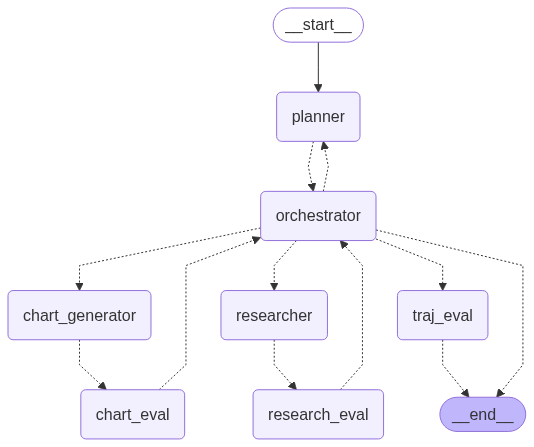

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
prompts = ["First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.",
    "Compare the stock prices of Uber and Lyft using a chart. Once you make the chart, describe the trends as shown and finish.",
    "How have the stock prices of the magnificent 7 stocks done over the past month? make a line chart of it. Once you make the chart, finish.",
    "How has the GDP of the G7 countries evolved over the last 20 years? Make a informational chart of it. Once you make the chart, explain which country has seen the highest average growth rate.",
    "What are the top 5 countries with the highest inequality in income? Use metrics from the World Bank or other reputable source. Make a chart that best illustrates the top 5 countries. Once the chart is generated, finish."
]

## Invoke

With the graph created, you can invoke it! Let's have it chart some stats for us.

{'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='abb04b67-6048-4985-ace3-17a7e8cb3e66')]}
----
{'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='abb04b67-6048-4985-ace3-17a7e8cb3e66'), HumanMessage(content='{\n  "1": {\n    "agent": "researcher",\n    "action": "retrieve_factual_data",\n    "goal": "Obtain the UK\'s GDP data for the past 5 years",\n    "pre_conditions": ["User requests UK\'s GDP over the past 5 years"],\n    "post_conditions": ["Structured data representing UK\'s GDP for the last 5 years is available"]\n  },\n  "2": {\n    "agent": "chart_generator",\n    "action": "create_line_chart",\n    "goal": "Generate a line chart from the UK\'s GDP data",\n    "pre_conditions": ["UK\'s GDP 

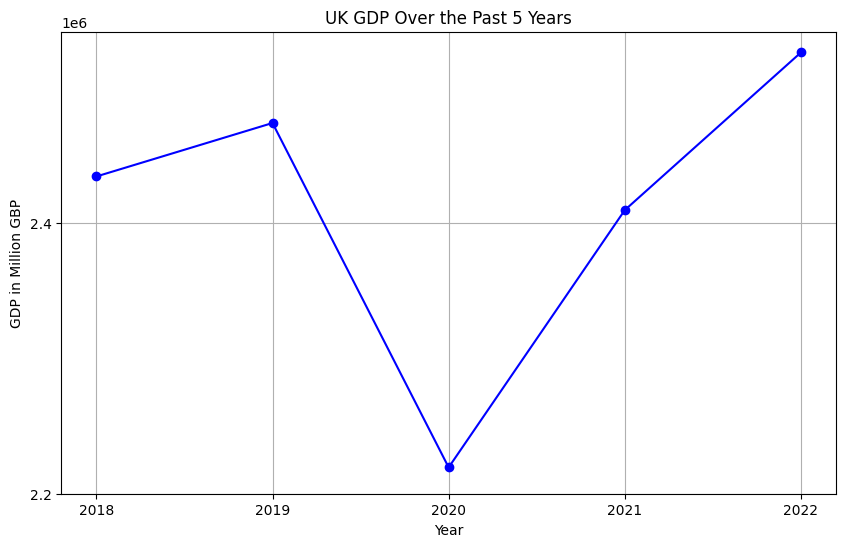

{'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='abb04b67-6048-4985-ace3-17a7e8cb3e66'), HumanMessage(content='{\n  "1": {\n    "agent": "researcher",\n    "action": "retrieve_factual_data",\n    "goal": "Obtain the UK\'s GDP data for the past 5 years",\n    "pre_conditions": ["User requests UK\'s GDP over the past 5 years"],\n    "post_conditions": ["Structured data representing UK\'s GDP for the last 5 years is available"]\n  },\n  "2": {\n    "agent": "chart_generator",\n    "action": "create_line_chart",\n    "goal": "Generate a line chart from the UK\'s GDP data",\n    "pre_conditions": ["UK\'s GDP data for the past 5 years is available"],\n    "post_conditions": ["A line chart visualizing the UK\'s GDP data over the past 5 years is created"]\n  },\n  "3": {\n    "agent": "traj_eval",\n    "action": "evaluate_and_conclude",\n    "goal":

In [18]:
thread_config = {"recursion_limit": 150, "configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            (
                "user",
               prompts[0],
            )
        ],
    },
    # Maximum number of steps to take in the graph
    thread_config, stream_mode="values"
)
for s in events:
    print(s)
    print("----")